In [1]:
# unet
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        # import pdb; pdb.set_trace()

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """softmax"""
        x = self.conv(x)
        # x = F.softmax(x, dim=1)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=2, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outpred = OutConv(32, n_classes)

    def forward(self, x):
        x = x/255.0
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outpred(x)
        return logits


In [2]:
# data
import os
import gc

import cv2
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


def load_file(filename):
    img = cv2.imread(filename, -1)
    img = img.astype(np.float32)
    return img


class CellDataset(Dataset):
    def __init__(self, txtpath, transform=data_transforms, data_reader=None):
        super(CellDataset, self).__init__()

        data_paths = []
        with open(txtpath, 'r') as fh:
            for line in fh:
                line = line.strip('\n')
                line = line.rstrip('\n')
                words = line.split()    # 0和1分别是cell和mask路径
                data_paths.append((words[0], words[1]))

        self.data_paths = data_paths
        self.transform = transform
        self.data_reader = data_reader
        pass

    def __getitem__(self, index):

        cell_path, mask_path = self.data_paths[index]
        cell = self.data_reader(cell_path)
        mask = self.data_reader(mask_path)

        # Normalization
        cell = cell - cell.min()
        cell = cell / cell.max() * 255

        if self.transform is not None:
            img = np.uint8([cell, mask, mask]).transpose(1, 2, 0)
            img = Image.fromarray(img)
            img = self.transform(img)
            cell = img[0]
            mask = img[1] * 255

        return cell, mask

    def __len__(self):
        return len(self.data_paths)


def get_dataset(cell_dir, mask_dir, valid_rate, tmp_dir, use_exist=True):

    valid_txt = tmp_dir + "valid_data.txt"
    train_txt = tmp_dir + "train_data.txt"

    use_exist = use_exist and os.path.isfile(
        valid_txt) and os.path.isfile(train_txt)

    if not use_exist:
        # generate list of file names
        cell_list = [os.path.join(cell_dir, image)
                     for image in os.listdir(cell_dir)]
        mask_list = [os.path.join(mask_dir, image)
                     for image in os.listdir(mask_dir)]

        # separate the lists according to valid_rate
        sample_size = len(cell_list)
        valid_size = int(sample_size * valid_rate)
        valid_index = np.random.choice(
            a=sample_size, size=valid_size, replace=False, p=None)

        # save the lists in txt files
        with open(valid_txt, "a+") as f:
            for i in valid_index:
                f.write(cell_list[i] + " " + mask_list[i] + '\n')

        with open(train_txt, "a+") as f:
            for i in range(sample_size):
                if i not in valid_index:
                    f.write(cell_list[i] + " " + mask_list[i] + '\n')

    # get the Dataset objects
    train_dataset = CellDataset(train_txt, data_reader=load_file)
    valid_dataset = CellDataset(valid_txt, data_reader=load_file)

    return train_dataset, valid_dataset


In [3]:
# validate
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torchvision.transforms as T


def CUDA(func):
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper


class Validator():

    def __init__(self, unet,
                 hyper_params,
                 use_cuda,
                 data_loader):
        self.unet = unet
        self.hyper_params = hyper_params
        self.use_cuda = use_cuda
        self.data_loader = data_loader
        pass

    def validate(self, SHOW_PIC=False, TTA=False):
        width_out = 628
        height_out = 628
        batch_size = self.hyper_params["batch_size"]
        use_cuda = self.use_cuda

        j_scores = []
        for i, data in enumerate(self.data_loader):

            """preprocess"""
            b_val_x, b_val_y = data

            """Test time augmentation"""
            # S b_val_x: [batch_size, width, height]
            if TTA:
                b_val_x_fh = torch.flip(b_val_x, dims=[1])
                b_val_x_fv = torch.flip(b_val_x, dims=[2])
                b_val_x_90 = torch.rot90(b_val_x, 1, dims=(1, 2))
                b_val_x_180 = torch.rot90(b_val_x, 2, dims=(1, 2))
                b_val_x_270 = torch.rot90(b_val_x, 3, dims=(1, 2))

                b_val_x_list = [
                    b_val_x,
                    b_val_x_fh,
                    b_val_x_fv,
                    b_val_x_90,
                    b_val_x_180,
                    b_val_x_270,
                ]
            else:
                b_val_x_list = [b_val_x]

            """get binary output"""
            # S b_val_x_list: [6 or 1, batch_size, width, height]

            b_y_list_cpu = []
            for b_x in b_val_x_list:

                # S b_x: [batch_size, width, height]
                if not isinstance(b_x, torch.Tensor):
                    b_x = T.ToTensor()(b_x)
                if (len(b_x.size()) == 3):
                    b_x = b_x.unsqueeze(1)
                elif (len(b_x.size() == 2)):
                    b_x = b_x.unsqueeze(0)
                    b_x = b_x.unsqueeze(1)

                # S b_x: [batch_size, 1, width, height]
                if use_cuda:
                    b_x = b_x.cuda()

                """get raw output"""
                b_predict_y = self.unet(b_x)

                """binarization"""
                # S b_predict_y: [batch_size, 2, width, height]
                b_predict_y_cpu = self.binarization(b_predict_y).detach().cpu()

                # S b_predict_y: [batch_size, width, height]
                b_y_list_cpu.append(b_predict_y_cpu)

            """Augmentation vote"""
            # S b_y_list_cpu: [6 or 1, batch_size, width, height]

            if TTA:
                # S b_y_list_cpu[n]: [batch_size, width, height]
                b_y_list_cpu[1] = torch.flip(b_y_list_cpu[1], dims=[1])
                b_y_list_cpu[2] = torch.flip(b_y_list_cpu[2], dims=[2])
                b_y_list_cpu[3] = torch.rot90(b_y_list_cpu[3], 3, dims=(1, 2))
                b_y_list_cpu[4] = torch.rot90(b_y_list_cpu[4], 2, dims=(1, 2))
                b_y_list_cpu[5] = torch.rot90(b_y_list_cpu[5], 1, dims=(1, 2))

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

                """Open operation"""
                for n in range(6):
                    b_y_list_cpu[n] = b_y_list_cpu[n].numpy()
                    for j in range(batch_size):
                        b_y_list_cpu[n][j] = cv2.morphologyEx(
                            src=b_y_list_cpu[n][j],
                            op=cv2.MORPH_OPEN,
                            kernel=kernel)
                    b_y_list_cpu[n] = torch.tensor(b_y_list_cpu[n])
                    b_y_list_cpu[n] = b_y_list_cpu[n].unsqueeze(0)

                """Vote"""
                # S b_y_list_cpu[n]: [1, batch_size, width, height]
                b_predict_y = torch.cat(tuple(b_y_list_cpu), dim=0)
                b_predict_y = torch.mean(b_predict_y, dim=0)

                # S b_predict_y: [batch_size, width, height]
                b_predict_y[b_predict_y > 0.5] = 1
                b_predict_y[b_predict_y <= 0.5] = 0

            else:
                b_predict_y = b_y_list_cpu[0]
                

            # S b_predict_y: [batch_size, width, height]
            b_predict_y = self.instance_sparse(b_predict_y)

            """Calculate jaccard score"""
            for j in range(batch_size):
                j_score = self.calc_jaccard(
                    b_predict_y[j], b_val_y[j], use_cuda=self.use_cuda)
                j_scores.append(j_score)

                if SHOW_PIC and j_score < 0.6:
                    b_val_x = b_val_x.cpu().detach().numpy()
                    b_predict_y = b_predict_y.cpu().detach().numpy()
                    comment = ("pic_num: %d, j_score: %f\n" % (i, j_score))
                    self.show_pic(picA=b_val_x[j],
                                  picB=b_val_y[j],
                                  picC=b_predict_y[j],
                                  comment=comment)
                pass
            pass  # end Calculate jaccard score
            

        print("j_scores_final:", np.array(j_scores))
        j_score = np.mean(j_scores)
        return j_score

    def binarization(self, batch_predict_y):
        # S b_predict_y: [batch_size, 2, width, height]

        # sqeeze
        batch_predict_y_1 = torch.softmax(batch_predict_y, dim=1)
        batch_predict_y_1 = batch_predict_y_1[:, 1, :, :]
        THRESHOLD_1 = 0.5
        batch_predict_y_1[batch_predict_y_1 > THRESHOLD_1] = 1
        batch_predict_y_1[batch_predict_y_1 <= THRESHOLD_1] = 0

        """
        # sqeeze
        batch_predict_y_raw = torch.tensor(batch_predict_y)
        batch_predict_y_2 = batch_predict_y[:, 1, :, :]
        # binarization
        THRESHOLD_2 = 0
        batch_predict_y_2[batch_predict_y_2 > THRESHOLD_2] = 1
        batch_predict_y_2[batch_predict_y_2 <= THRESHOLD_2] = 0
        """
        batch_predict_y = batch_predict_y_1
        # S b_predict_y: [batch_size, width, height]

        return batch_predict_y

    def instance_sparse(self, batch_predict_y, KERNEL_SIZE=(6, 6)):
        """Post process the result."""
        # shape: [batch_size, width, height]
        
        res = []
        for predict_y in batch_predict_y:
            predict_y = predict_y.numpy().astype(np.uint8) * 255
            
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

            """Open operation"""
            predict_y = cv2.morphologyEx(
                    src=predict_y,
                    op=cv2.MORPH_OPEN,
                    kernel=kernel
            )
            
            if cv2.__version__[0] == '3':
                __, contours, _ = cv2.findContours(
                    predict_y, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 寻找连通域
            elif cv2.__version__[0] == '4':
                contours, _ = cv2.findContours(
                    predict_y, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 寻找连通域

            areas = [cv2.contourArea(cnt) for cnt in contours]
            cellIndexs = np.argsort(areas)
            
            print("len(cellIndexs):", len(cellIndexs))

            predict_y = np.zeros([predict_y.shape[0], predict_y.shape[1]])
            for j in range(len(cellIndexs)):
                cv2.drawContours(predict_y, contours, j, j, cv2.FILLED)
                
            predict_y = predict_y.astype(int)
            res.append(predict_y)
        

        res = torch.Tensor(res)
        return res


    def calc_jaccard(self, imgA, imgB, use_cuda=True):
        """Calculate the jaccard score"""
        """All this may occur in GPU."""
        
        self.show_pic(imgA, imgB, is_gray=(True, True))
        if use_cuda:
            imgA = imgA.cuda()
            imgB = imgB.cuda()

        unqA = torch.unique(imgA)
        unqB = torch.unique(imgB)
        num_A = len(unqA)
        num_B = len(unqB)
        print(num_A, num_B)

        if num_A < num_B:
            imgA, imgB = imgB, imgA
            num_A, num_B = num_B, num_A
            unqA, unqB = unqB, unqA

        for i in range(num_A):
            imgA[imgA == unqA[i]] = i
        for i in range(num_B):
            imgB[imgB == unqB[i]] = i

        hit_matrix = np.zeros([num_A, num_B])

        if use_cuda:
            for i in range(2, num_A):
                A_chan = (imgA == i).cuda()
                for j in range(1, num_B):
                    B_chan = (imgB == j).cuda()
                    A_and_B = torch.mul(A_chan, B_chan)
                    B_chan[A_chan == 1] = 1
                    hit_matrix[i, j] = torch.sum(
                        A_and_B).float() / torch.sum(B_chan).float()
        else:
            for i in range(2, num_A):
                A_chan = (imgA == i)
                for j in range(1, num_B):
                    B_chan = (imgB == j)
                    A_and_B = torch.mul(A_chan, B_chan)
                    B_chan[A_chan == 1] = 1
                    hit_matrix[i, j] = torch.sum(
                        A_and_B).float() / torch.sum(B_chan).float()

        jaccard_list = []
        for j in range(1, num_B):
            jac_col = np.max(hit_matrix[:, j])
            if jac_col > 0.5:
                jaccard_list.append(jac_col)
            else:
                jaccard_list.append(0)

        j_score = np.sum(jaccard_list) / max(num_A, num_B)
        return j_score

    def show_pic(self, picA, picB, picC=None,
                 is_gray=(True, False, False), comment=""):
        plt.subplot(1, 3, 1)
        plt.title("x")
        if is_gray[0]:
            plt.imshow(picA, cmap='gray')
        else:
            plt.imshow(picA)

        plt.subplot(1, 3, 2)
        plt.title("GT")
        if is_gray[1]:
            plt.imshow(picB, cmap='gray')
        else:
            plt.imshow(picB)

        if picC is not None:
            plt.subplot(1, 3, 3)
            plt.title("Predict")
            if is_gray[2]:
                plt.imshow(picC, cmap='gray')
            else:
                plt.imshow(picC)

        if comment is not "":
            plt.text(0, 1, comment, fontsize=14)

        plt.show()


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader


class Tester():

    def __init__(self, module_path, cell_dir, mask_dir, tmp_dir,
                 hyper_params, use_cuda, test_rate=1.0, use_exist=False):

        print("Test rate:", test_rate)
        self.dataset, _ = get_dataset(
            cell_dir, mask_dir, 1 - test_rate, tmp_dir, use_exist=use_exist)
        print("test number:", len(self.dataset))

        self.hyper_params = hyper_params
        self.data_loader = DataLoader(
            dataset=self.dataset,
            num_workers=self.hyper_params["threads"],
            batch_size=self.hyper_params["batch_size"],
            shuffle=False
        )

        self.unet = UNet(n_channels=1, n_classes=2,)
        self.unet.load_state_dict(torch.load(module_path))
        if use_cuda:
            self.unet = self.unet.cuda()

        self.v = Validator(unet=self.unet,
                           hyper_params=self.hyper_params,
                           use_cuda=use_cuda,
                           data_loader=self.data_loader)

    def test(self, SHOW_PIC=False, TTA=False):
        return self.v.validate(SHOW_PIC=SHOW_PIC, TTA=TTA)
    pass


Test rate: 0.1
test number: 234
len(cellIndexs): 15


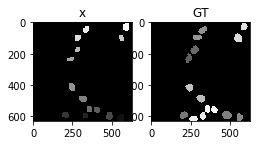

15 16


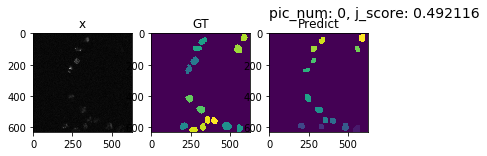

len(cellIndexs): 6


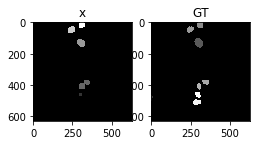

6 10


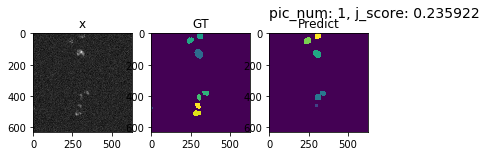

len(cellIndexs): 17


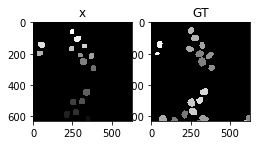

17 24


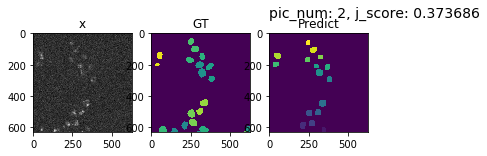

len(cellIndexs): 16


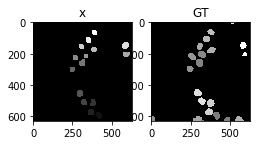

16 23


KeyboardInterrupt: 

In [6]:
hyper_parameters = {
    "batch_size": 1,
    "threads": 0,
}

cell_dir = "C:/me/dataset1/train/"
mask_dir = "C:/me/dataset1/train_GT/SEG/"
tmp_dir = "C:/me/test/_tmp/_test/"
use_cuda = True
SHOW_PIC = True
TTA = False

for e in range(200, 250, 50):

    module_path = "C:/me/test/save/unet-20200524143714.pth"

    tester = Tester(
        module_path=module_path,
        cell_dir=cell_dir,
        mask_dir=mask_dir,
        tmp_dir=tmp_dir,
        hyper_params=hyper_parameters,
        use_cuda=use_cuda,
        use_exist=False,
        test_rate=0.1,
    )
    import time
    tic = time.time()
    test_acc = tester.test(
        SHOW_PIC=SHOW_PIC,
        TTA=TTA
    )
    toc = time.time()
    print("test accuracy:",
          test_acc, "time:", toc - tic)